In [1]:
import sys
print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [2]:
import math
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline

* State: x position [m], y position [m], yaw [rad]

\begin{align*}
\textbf{x}_t =
\begin{bmatrix}
    x_t \\
    y_t \\
    \theta_t \\
\end{bmatrix}
\end{align*}

* Input: speed [m/s], yaw rate [rad/s]

\begin{align*}
\textbf{u}_t =
\begin{bmatrix}
    v_t \\
    \omega_t \\
\end{bmatrix}
\end{align*}

* Observation: x position [m], y position [m]

$$
\textbf{z}_t =
\begin{bmatrix}
    x_t \\
    y_t \\
\end{bmatrix}
$$

# Parameters

In [3]:
DIM_X = 3 ### State dimension: x [m], y [m], theta [rad]
DIM_Z = 2 ### Observation dimension: x [m], y [m]

DELTA_TIME = 0.1 # [s]
END_TIME = 30.0 # [s]

INPUT_COV = np.diag([
    1.0**2, # [m^2/s^2] variance of speed input
    np.deg2rad(30.0)**2 # [rad^2/s^2] variance of yaw rate input
])

GNSS_COV = np.diag([
    0.5**2, # [m^2] variance of x reading
    0.5**2 # [m^2] variance of y reading
])

In [4]:
### Process noise covariance
Q = np.diag([
    0.1**2, # [m^2] variance of x
    0.1**2, # [m^2] variance of y
    np.deg2rad(1.0)**2 # [rad^2] variance of yaw
])

### Observation noise covariance
R = np.diag([
    1.0**2, # [m^2] variance of x
    1.0**2 # [m^2] variance of y
])

In [5]:
### UKF parameters
ALPHA = 0.001
BETA = 2
KAPPA = 0

# Functions

In [6]:
def ChooseSigmaPoints(x, P, lamb):
    x_sigma_pnts = x
    P_sqrt = scipy.linalg.sqrtm(P)

    for i in range(DIM_X):
        x_sigma_pnts_pstv = x + math.sqrt(DIM_X + lamb)*P_sqrt[:, i:i+1]
        x_sigma_pnts = np.hstack((x_sigma_pnts, x_sigma_pnts_pstv))

    for i in range(DIM_X):
        x_sigma_pnts_ngtv = x - math.sqrt(DIM_X + lamb)*P_sqrt[:, i:i+1]
        x_sigma_pnts = np.hstack((x_sigma_pnts, x_sigma_pnts_ngtv))

    return x_sigma_pnts

In [7]:
def CalcSigmaCovariance(mean, sigma_pnts, weights_cov, P_add):
    deviation = sigma_pnts - mean
    assert deviation.shape == (mean.shape[0], 2*DIM_X + 1)

    P = np.zeros((mean.shape[0], mean.shape[0]))
    for i in range(2*DIM_X + 1):
        P += weights_cov[0, i] * deviation[:, i:i+1]@deviation[:, i:i+1].T

    P += P_add

    return P

In [8]:
def CalcStateObservationCorrelation(x_mean, x_sigma_pnts, z_mean, z_sigma_pnts, weights_cov):
    deviation_x = x_sigma_pnts - x_mean
    assert deviation_x.shape == (x_mean.shape[0], 2*DIM_X + 1)

    deviation_z = z_sigma_pnts - z_mean
    assert deviation_z.shape == (z_mean.shape[0], 2*DIM_X + 1)

    C_x_z = np.zeros((x_mean.shape[0], z_mean.shape[0]))
    for i in range(2*DIM_X + 1):
        C_x_z += weights_cov[0, i] * deviation_x[:, i:i+1]@deviation_z[:, i:i+1].T

    return C_x_z

Motion model (Non-linear):

\begin{align*}
\textbf{x}_t & = \textbf{f} (\textbf{x}_{t-1}, \textbf{u}_t) + \textbf{w}
\\
& = 
\begin{bmatrix}
    x_{t-1} + v_t \Delta t \cos \theta_{t-1} \\
    y_{t-1} + v_t \Delta t \sin \theta_{t-1} \\
    \theta_{t-1} + \omega_t \Delta t \\
\end{bmatrix}
+
\textbf{w}
\end{align*}

, where $\textbf{w}$ is process noise whose covariance is $Q$.

### 1. Motion predict step

In [9]:
### Non-linear
def MotionModel(x_prev, u_curr):
    x_pos_prev = x_prev[0, 0] # [m]
    y_pos_prev = x_prev[1, 0] # [m]
    yaw_prev = x_prev[2, 0] # [rad]

    speed_curr = u_curr[0, 0] # [m/s]
    yaw_rate_curr = u_curr[1, 0] # [rad/s]

    x_curr = np.array([
        [x_pos_prev + speed_curr*DELTA_TIME*math.cos(yaw_prev)],
        [y_pos_prev + speed_curr*DELTA_TIME*math.sin(yaw_prev)],
        [yaw_prev + yaw_rate_curr*DELTA_TIME]
    ])

    assert x_curr.shape == (DIM_X, 1)

    return x_curr



def UKF_MotionPredict(x_prev_post, u_curr_noisy, P_prev_post, lamb, weights_mean, weights_cov):
    x_sigma_pnts_prev_post = ChooseSigmaPoints(x_prev_post, P_prev_post, lamb)

    ### State transition of sigma points
    x_sigma_pnts_curr_prior = np.empty_like(x_sigma_pnts_prev_post)
    for i in range(2*DIM_X + 1):
        x_sigma_pnts_curr_prior[:, i:i+1] = MotionModel(x_sigma_pnts_prev_post[:, i:i+1], u_curr_noisy)

    assert x_sigma_pnts_prev_post.shape == (DIM_X, 2*DIM_X + 1)
    assert x_sigma_pnts_curr_prior.shape == (DIM_X, 2*DIM_X + 1)

    x_curr_prior = x_sigma_pnts_curr_prior@weights_mean.T
    P_curr_prior = CalcSigmaCovariance(x_curr_prior, x_sigma_pnts_curr_prior, weights_cov, Q)

    assert x_curr_prior.shape == (DIM_X, 1)
    assert P_curr_prior.shape == (DIM_X, DIM_X)

    return x_curr_prior, P_curr_prior

Observation model (Linear):

\begin{align*}
\textbf{z}_t & = H \textbf{x}_t + \textbf{v}
\\
& = 
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
\end{bmatrix}
\textbf{x}_t
+
\textbf{v}
\\
& = 
\begin{bmatrix}
    x_t \\
    y_t \\
\end{bmatrix}
+
\textbf{v}
\end{align*}

, where $\textbf{v}$ is observation noise whose covariance is $R$.

### 2. Measurement update step

In [10]:
### Observation model matrix
H = np.array([
    [1, 0, 0],
    [0, 1, 0]
])



### Linear
def ObservationModel(x_curr):
    z_curr = H@x_curr

    return z_curr



def KF_MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr):
    S = H@P_curr_prior@H.T + R ### Observation residual covariance (Innovation covariance)
    K = (P_curr_prior@H.T)@np.linalg.inv(S) ### Kalman gain

    x_curr_post = x_curr_prior + K@(z_curr - ObservationModel(x_curr_prior))
    P_curr_post = (np.eye(len(x_curr_post)) - K@H)@P_curr_prior
   
    return x_curr_post, P_curr_post




def UKF_MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr, lamb, weights_mean, weights_cov):
    x_sigma_pnts_curr_prior = ChooseSigmaPoints(x_curr_prior, P_curr_prior, lamb)

    ### State transition of sigma points
    z_sigma_pnts_curr_prior = np.empty((DIM_Z, 2*DIM_X + 1))
    for i in range(2*DIM_X + 1):
        z_sigma_pnts_curr_prior[:, i:i+1] = ObservationModel(x_sigma_pnts_curr_prior[:, i:i+1])

    z_curr_prior = z_sigma_pnts_curr_prior@weights_mean.T
    S_curr_prior = CalcSigmaCovariance(z_curr_prior, z_sigma_pnts_curr_prior, weights_cov, R) ### Covariance of predicted observation

    assert z_curr_prior.shape == (DIM_Z, 1)
    assert S_curr_prior.shape == (DIM_Z, DIM_Z)

    C_x_z = CalcStateObservationCorrelation(x_curr_prior, x_sigma_pnts_curr_prior, z_curr_prior, z_sigma_pnts_curr_prior, weights_cov)

    K = C_x_z@np.linalg.inv(S_curr_prior) ### Kalman gain 

    x_curr_post = x_curr_prior + K@(z_curr - ObservationModel(x_curr_prior))
    P_curr_post = P_curr_prior - K@S_curr_prior@K.T
   
    return x_curr_post, P_curr_post

In [11]:
def UKF_predict_UKF_update(x_prev_post, P_prev_post, u_curr_noisy, z_curr, lamb, weights_mean, weights_cov):
    x_curr_prior, P_curr_prior = UKF_MotionPredict(x_prev_post, u_curr_noisy, P_prev_post, lamb, weights_mean, weights_cov)
    x_curr_post, P_curr_post = UKF_MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr, lamb, weights_mean, weights_cov)

    return x_curr_post, P_curr_post



def UKF_predict_KF_update(x_prev_post, P_prev_post, u_curr_noisy, z_curr, lamb, weights_mean, weights_cov):
    x_curr_prior, P_curr_prior = UKF_MotionPredict(x_prev_post, u_curr_noisy, P_prev_post, lamb, weights_mean, weights_cov)
    x_curr_post, P_curr_post = KF_MeasurementUpdate(x_curr_prior, P_curr_prior, z_curr)

    return x_curr_post, P_curr_post

In [12]:
def PlotCovEllipse(x_est, P_est, color, linestyle=None, print_flag=False):
    P_est_xy = P_est[0:2, 0:2]
    eig_val, eig_vec = np.linalg.eig(P_est_xy)

    '''
    eig_val = [ l1, l2 ]

    eig_vec = [
        [v1_x, v2_x],
        [v1_y, v2_y],
    ]
    '''

    major_idx = np.argmax(eig_val)
    minor_idx = np.argmin(eig_val)
  
    semi_major = math.sqrt(eig_val[major_idx])
    semi_minor = math.sqrt(eig_val[minor_idx])

    step = 0.1
    ts = np.arange(0.0, 2*math.pi + step, step)
    
    xs = np.array([semi_major*math.cos(t) for t in ts])
    ys = np.array([semi_minor*math.sin(t) for t in ts])

    major_eig_vec_x = eig_vec[0, major_idx]
    major_eig_vec_y = eig_vec[1, major_idx]
    theta = math.atan2(major_eig_vec_y, major_eig_vec_x)

    rot = np.array([
        [math.cos(theta), -math.sin(theta)],
        [math.sin(theta), math.cos(theta)]
    ])

    fx = rot@np.array([xs, ys])
    px = fx[0, :] + x_est[0, 0]
    py = fx[1, :] + x_est[1, 0]
    
    plt.plot(px, py, color=color, linestyle=linestyle)

    if print_flag:
        print('eig_val =', eig_val, '\n')
        print('eig_vec = \n', eig_vec, '\n')
        print('major_idx =', major_idx, ', minor_idx =', minor_idx, '\n')
        print('theta =', round(np.rad2deg(theta), 2), '[deg] \n')

    return



def PlotTrajectory(xs_GT, xs_DR, xs_est1,  xs_est2, zs, x_est_curr1, P_est_curr1, x_est_curr2, P_est_curr2):
    xs_GT_np = np.array(xs_GT)
    xs_DR_np = np.array(xs_DR)
    xs_est_np1 = np.array(xs_est1)
    xs_est_np2 = np.array(xs_est2)
    zs_np = np.array(zs)

    plt.plot(xs_GT_np[:, 0], xs_GT_np[:, 1], color='blue', label='Ground Truth')
    plt.plot(xs_DR_np[:, 0], xs_DR_np[:, 1], color='black', label='Dead Reckoning')

    plt.plot(xs_est_np1[:, 0], xs_est_np1[:, 1], color='gold', label='UKF predict + UKF update')
    PlotCovEllipse(x_est_curr1, P_est_curr1, color='gold')

    plt.plot(xs_est_np2[:, 0], xs_est_np2[:, 1], color='purple', linestyle='dotted', label='UKF predict + KF update')
    PlotCovEllipse(x_est_curr2, P_est_curr2, color='purple', linestyle='dotted')

    plt.scatter(zs_np[:, 0], zs_np[:, 1], color='green', s=2, label='Observation')

    plt.xticks(np.arange(-100, 100, 5))
    plt.yticks(np.arange(-100, 100, 5))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.axis('equal')

    return

# Main

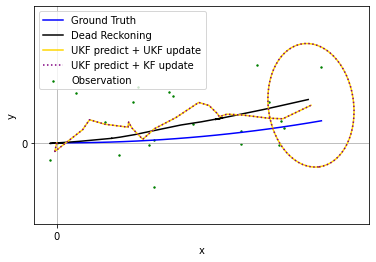

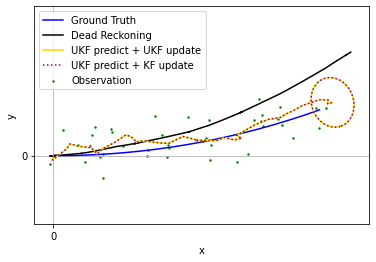

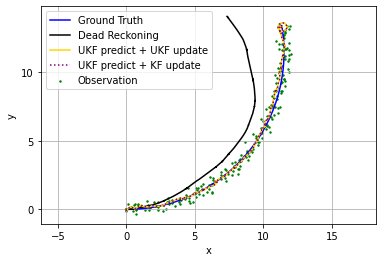

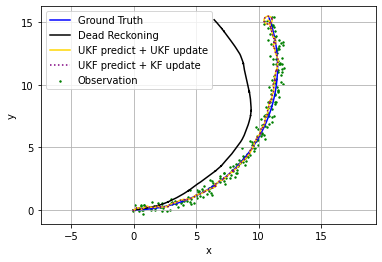

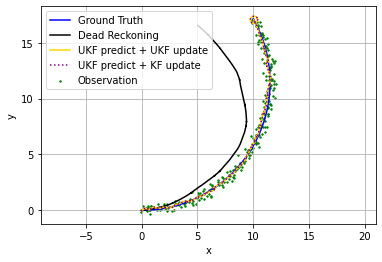

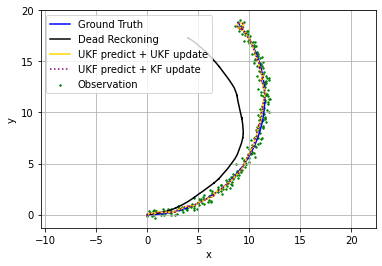

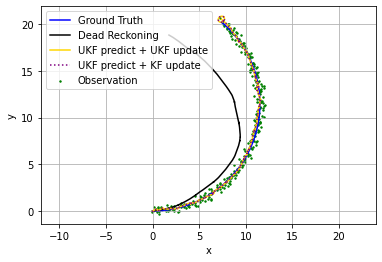

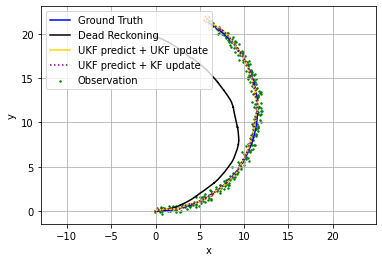

In [13]:
lamb = ALPHA**2 * (DIM_X + KAPPA) - DIM_X

weight_0 = lamb / (DIM_X + lamb)
weights_mean = np.array([weight_0])
weights_cov = np.array([weight_0 + (1 - ALPHA**2 + BETA)])

for i in range(2*DIM_X):
    weight_i = 1.0 / (2*(DIM_X + lamb))
    weights_mean = np.append(weights_mean, weight_i)   
    weights_cov = np.append(weights_cov, weight_i)

weights_mean = np.expand_dims(weights_mean, axis=0) ### shape = (2*DIM_X + 1,) ---> (1, 2*DIM_X + 1)
weights_cov = np.expand_dims(weights_cov, axis=0) ### shape = (2*DIM_X + 1,) ---> (1, 2*DIM_X + 1)
assert weights_mean.shape == (1, 2*DIM_X + 1)
assert weights_cov.shape == (1, 2*DIM_X + 1)

x_GT_init = np.zeros((DIM_X, 1)) ### Ground Truth
x_DR_init = np.zeros((DIM_X, 1)) ### Dead Reckoning

x_est_init = np.zeros((DIM_X, 1))
P_est_init = np.eye(DIM_X)

z_init = np.zeros((DIM_Z, 1))

xs_GT = [x_GT_init]
xs_DR = [x_DR_init]
xs_est1 = [x_est_init]
xs_est2 = [x_est_init]
zs = [z_init]

x_GT_prev = x_GT_init
x_DR_prev = x_DR_init
x_est_prev1 = x_est_init
P_est_prev1 = P_est_init
x_est_prev2 = x_est_init
P_est_prev2 = P_est_init

t = 0.0

while t < END_TIME:
    ### Input command ... NOTE: "u_curr.shape" must be (2, 1), not (2,)
    speed_curr = 1.0 # [m/s]
    yaw_rate_curr = np.deg2rad(5.0) # [m/s]
    u_curr = np.array([
        [speed_curr],
        [yaw_rate_curr],
    ])
    
    ### Ground Truth state
    x_GT_curr = MotionModel(x_GT_prev, u_curr)

    ### Dead Reckoning state
    input_noise = INPUT_COV @ np.random.randn(2, 1)
    u_curr_noisy = u_curr + input_noise
    x_DR_curr = MotionModel(x_DR_prev, u_curr_noisy)

    ### Observation
    gnss_noise = GNSS_COV @ np.random.randn(2, 1)
    z_curr = ObservationModel(x_GT_curr) + gnss_noise

    ### Unscented Kalman Filter estimation
    x_est_curr1, P_est_curr1 = UKF_predict_UKF_update(x_est_prev1, P_est_prev1, u_curr_noisy, z_curr, lamb, weights_mean, weights_cov)
    x_est_curr2, P_est_curr2 = UKF_predict_KF_update(x_est_prev2, P_est_prev2, u_curr_noisy, z_curr, lamb, weights_mean, weights_cov)

    xs_GT.append(x_GT_curr)
    xs_DR.append(x_DR_curr)
    xs_est1.append(x_est_curr1)
    xs_est2.append(x_est_curr2)
    zs.append(z_curr)

    if np.isclose((t + DELTA_TIME) % 2.0, 0.0, atol=1.0e-6):
        PlotTrajectory(xs_GT, xs_DR, xs_est1,  xs_est2, zs, x_est_curr1, P_est_curr1, x_est_curr2, P_est_curr2,)
        plt.pause(0.001)

    x_GT_prev = x_GT_curr
    x_DR_prev = x_DR_curr
    x_est_prev1 = x_est_curr1
    P_est_prev1 = P_est_curr1
    x_est_prev2 = x_est_curr2
    P_est_prev2 = P_est_curr2

    t += DELTA_TIME

In [14]:
xs_est_np1 = np.array(xs_est1)
xs_est_np2 = np.array(xs_est2)

xs1 = xs_est_np1[:, 0]
ys1 = xs_est_np1[:, 1]
thetas1 = xs_est_np1[:, 2]

xs2 = xs_est_np2[:, 0]
ys2 = xs_est_np2[:, 1]
thetas2 = xs_est_np2[:, 2]

x_rmse = math.sqrt(np.mean((xs1 - xs2)**2))
y_rmse = math.sqrt(np.mean((ys1 - ys2)**2))
theta_rmse = math.sqrt(np.mean((thetas1 - thetas2)**2))

print('x_rmse = %.12f' % x_rmse, '[m]')
print('y_rmse = %.12f' % y_rmse, '[m]')
print('theta_rmse = %.12f' % theta_rmse, '[m]')

x_rmse = 0.000000002401 [m]
y_rmse = 0.000000002532 [m]
theta_rmse = 0.000000000940 [m]
